# FAIR

*Object oriented version*

This notebook gives some simple examples of how to run and use the Finite Amplitude Impulse Response (FAIR) model. 

The  Finite  Amplitude  Impulse  Response  (FAIR)  model  is  a  simple  climate model. It allows the user to prescribed CO$_2$ emissions or radiative forcing, non-CO$_2$ radiative forcing and climate and carbon cycle parameters in order to estimate global mean atmospheric CO$_2$ concentrations, radiative forcing and temperature anomalies.

It was developed by Richard Millar, Zebedee Nicholls, Pierre Friedlingstein and Myles Allen. The motivation for developing it and its formulation is documented in  a  paper  published  in  Atmospheric  Chemistry  and  Physics  in  2017 (doi:10.5194/acp-2016-405).

In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair.scm
fair.__version__


'0.0.0.dev'

## Basic run
Here we show how FAIR can be run with step change CO$_2$ emissions and sinusoidal non-CO$_2$ forcing timeseries.

(<matplotlib.figure.Figure at 0x7f9126a07210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f911e918e90>)

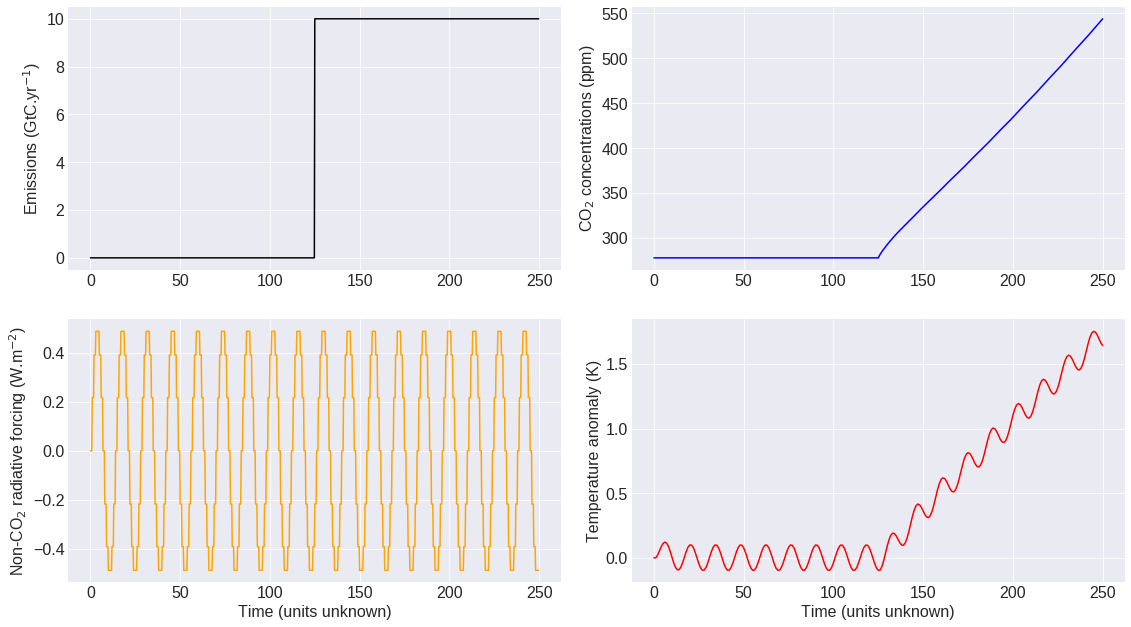

In [2]:
# set emissions
emissions = np.zeros(250)
emissions[125:] = 10.0
# set other radiative forcing
other_rf = np.zeros(emissions.size)
for x in range(0,emissions.size):
    other_rf[x] = 0.5*np.sin(2*np.pi*(x)/14.0)

# start our FAIR class instance
base_run = fair.scm.FAIR(emissions=emissions,
                         other_rf=other_rf)
# run FAIR
base_run.run()
# plot it
base_run.plot()

## Emissions only
We can also run FAIR with just CO$_2$ emissions and no forcing.

(<matplotlib.figure.Figure at 0x7f911e9e72d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f911e7401d0>)

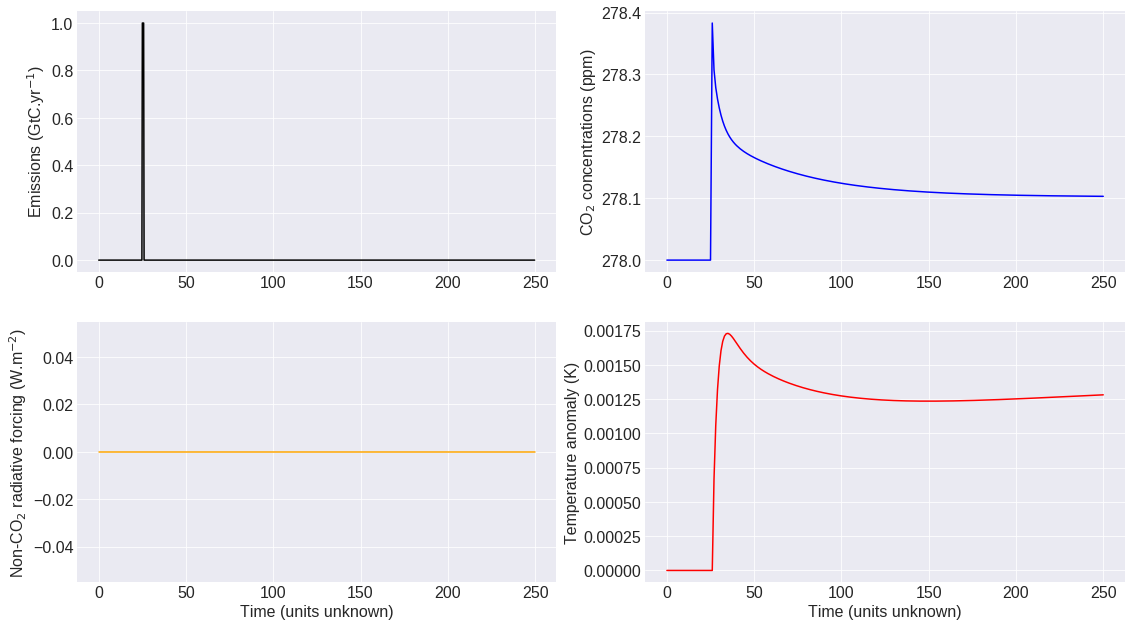

In [3]:
emissions = np.zeros(250)
emissions[25] = 1.0
other_rf = 0.0

emms_only = fair.scm.FAIR(emissions=emissions,
                         other_rf=other_rf)
# run FAIR
emms_only.run()
# plot it
emms_only.plot()

## Forcing only
Or we can set emissions to zero and just have radiative forcing. Here we simply have a step change in radiative forcing from 0.0 W.m$^{-2}$ to RF$_{2 \times CO_2} = 3.74$ W.m$^{-2}$

(<matplotlib.figure.Figure at 0x7f911e4e19d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f911cacc4d0>)

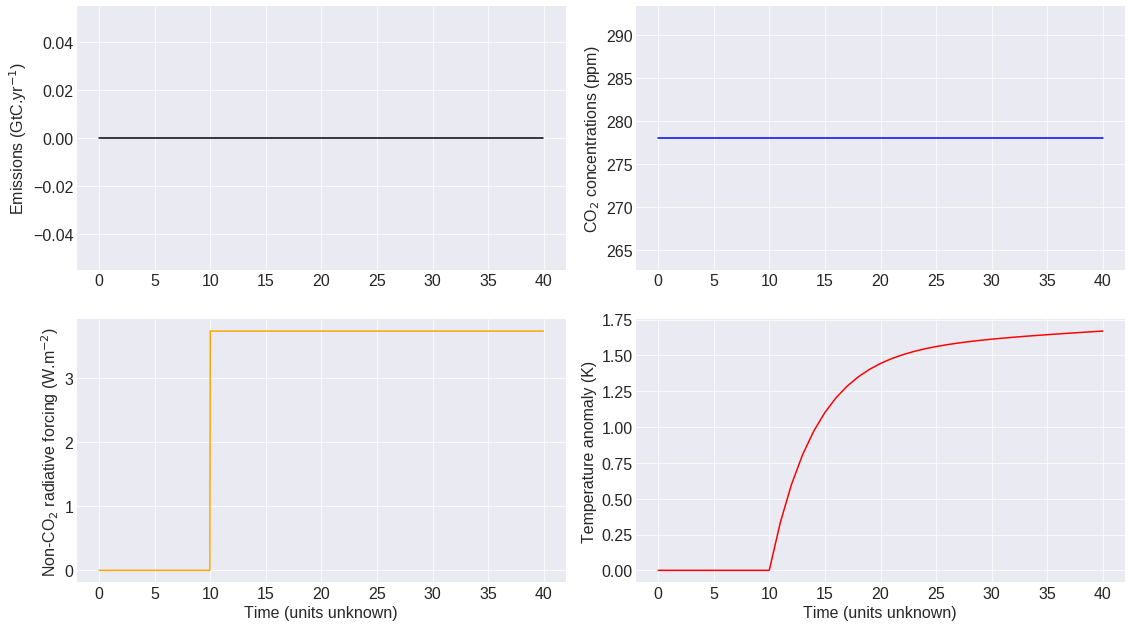

In [4]:
emissions = False
other_rf = np.zeros(40)
other_rf[10:] = 3.74

emms_only = fair.scm.FAIR(emissions=emissions,
                         other_rf=other_rf)
# run FAIR
emms_only.run()
# plot it
emms_only.plot()

# ECS and TCR


Here we perform a 1% per year increase in CO$_2$ concentration with stabilisation experiment to confirm that our input values of ECS and TCR actually manifest.

CO2 levels capped at: 556.0329ppmv
Diagnosed TCR: 1.6001K
Diagnosed ECS: 2.7499K


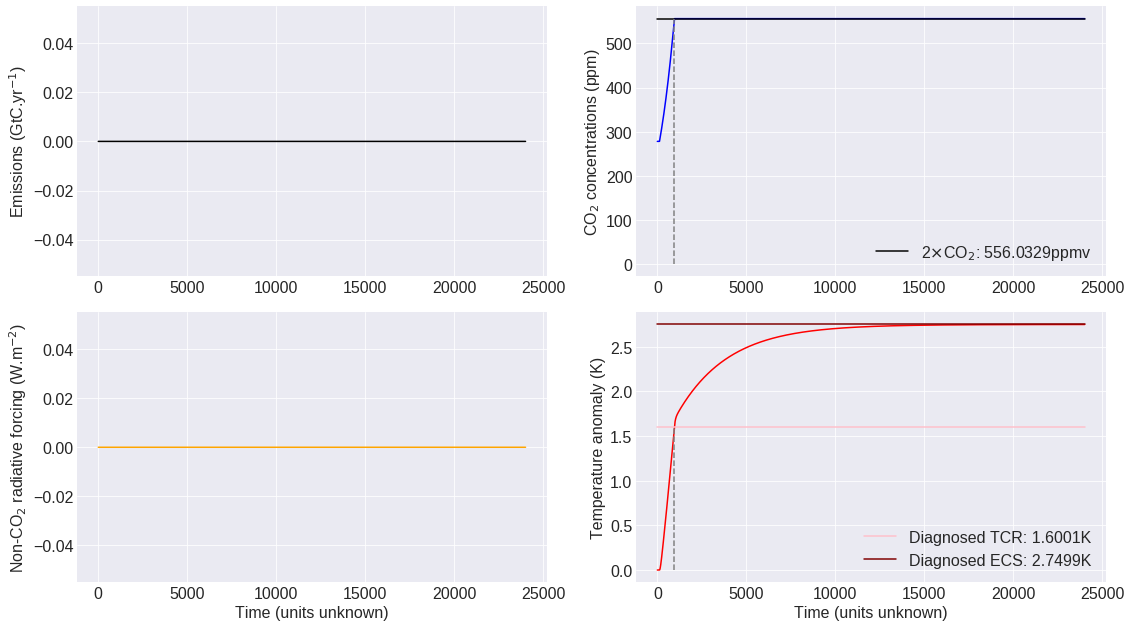

In [5]:
# To get the doubling slightly more accurate, we use a monthly
# concentrations time series rather than an annual one

# make a 2000 year long timeseries
co2_concs = np.zeros(2000*12)
# set pre-industrial atmospheric CO_2
C_0 = 278.0
# set number of months of pre-industrial concs
pic = 120
# CO_2 concentrations are initially constant
co2_concs[0:pic] = C_0
# ecrtcs_run.Then they rise at 1 percent per year until they double in August of 
# year 69
dblt = 12*69+8
co2_concs[pic:pic + dblt + 1] = C_0*(1.01**(np.arange(0,dblt+1)/12.0))
print 'CO2 levels capped at: {0:.4f}ppmv'.format(co2_concs[pic+dblt])
# after this we make them constant once again
co2_concs[pic + dblt:] = co2_concs[pic + dblt]

ecrtcs_run = fair.scm.FAIR(tstep=1/12.0,
                           co2_concs=co2_concs,
                           C_0=C_0,
                           tcrecs=[1.6,2.75])
ecrtcs_run.run()
fig,emmsax,concax,forcax,tempax = ecrtcs_run.plot()

# bring plot inline so we can modify it
# %matplotlib inline

concax.plot([0,len(ecrtcs_run.C)],[2*C_0,2*C_0],color='black',label=r'2$\times$CO$_2$: {0:.4f}ppmv'.format(co2_concs[12*79+8]))
concax.plot([pic+dblt,pic+dblt],[0.0,2.0*C_0],color='grey',ls='--')
concax.legend()

tempax.plot([0,len(ecrtcs_run.C)],[ecrtcs_run.T[pic+dblt+1],ecrtcs_run.T[pic+dblt+1]],color='pink',label='Diagnosed TCR: {0:.4f}K'.format(ecrtcs_run.T[pic+dblt+1]))
tempax.plot([pic+dblt,pic+dblt],[0.0,ecrtcs_run.T[pic+dblt+1]],color='grey',ls='--')
tempax.plot([0,len(ecrtcs_run.C)],[ecrtcs_run.T[-1],ecrtcs_run.T[-1]],color='maroon',label='Diagnosed ECS: {0:.4f}K'.format(ecrtcs_run.T[-1]))
tempax.legend()

fig.tight_layout()

# In FAIR, the radiative forcing due to increases in CO2 concentrations
# isn't actually seen by the climate system until a year after they happen
# (see FAIR-maths.pdf for an explanation of why this has to be the case). 
# As a result, it's necessary to look at the temperature the year after CO2 
# concentrations double to determine ecrtcs_run.TCS, rather than in the year of doubling,
# as this point represents the climate system's actual response to the 
# full linear increase in forcing. If we didn't do this, we'd be chopping off
# the last year of forcing.

print 'Diagnosed TCR: {0:.4f}K'.format(ecrtcs_run.T[pic+dblt+1])
print 'Diagnosed ECS: {0:.4f}K'.format(ecrtcs_run.T[-1])

The plot above isn't very illuminating so we can split our axes instead

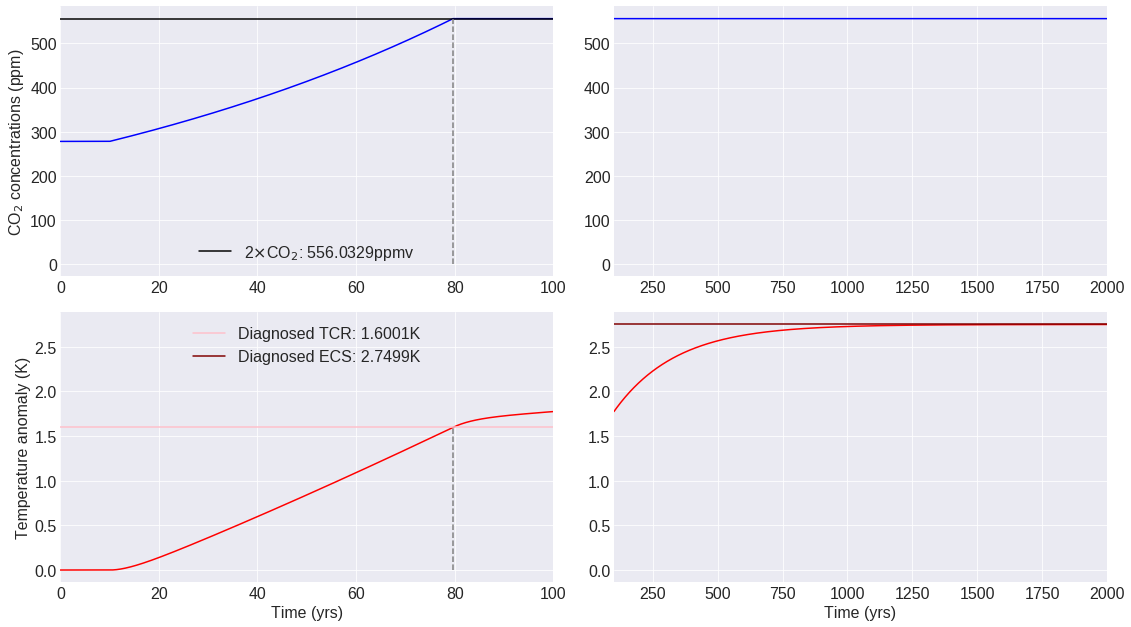

In [6]:
spltyr = 100
spltmon = spltyr*12

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(np.arange(0,spltmon)/12.0,ecrtcs_run.C[:spltmon],color='blue')
ax1.plot([0,spltyr],[2*ecrtcs_run.C_0,2*ecrtcs_run.C_0],color='black',label=r'2$\times$CO$_2$: {0:.4f}ppmv'.format(co2_concs[12*79+8]))
ax1.plot([(pic+dblt)/12.0,(pic+dblt)/12.0],[0.0,2.0*ecrtcs_run.C_0],color='grey',ls='--')
ax1.legend(loc='lower center')
ax1.set_ylabel('CO$_2$ concentrations (ppm)')
ax1.set_xlim([0,spltyr])

ax2 = fig.add_subplot(222, sharey=ax1)
ax2.plot(np.arange(spltmon,ecrtcs_run.C.size)/12.0,ecrtcs_run.C[spltmon:],color='blue')
ax2.set_ylabel('')

ax3 = fig.add_subplot(223)
ax3.plot(np.arange(0,spltmon)/12.0,ecrtcs_run.T[:spltmon],color='red')
ax3.plot([(pic+dblt)/12.0,(pic+dblt)/12.0],[0.0,ecrtcs_run.T[pic+dblt+1]],color='grey',ls='--')
lns = ax3.plot([0.0,spltyr],[ecrtcs_run.T[pic+dblt+1],ecrtcs_run.T[pic+dblt+1]],color='pink',label='Diagnosed TCR: {0:.4f}K'.format(ecrtcs_run.T[pic+dblt+1]))
ax3.set_ylabel('Temperature anomaly (K)')
ax3.set_xlabel('Time (yrs)')
ax3.set_xlim([0,spltyr])

ax4 = fig.add_subplot(224, sharey=ax3,sharex=ax2)
ax4.plot(np.arange(spltmon,ecrtcs_run.C.size)/12.0,ecrtcs_run.T[spltmon:],color='red')
lns += ax4.plot([spltyr,ecrtcs_run.C.size/12.0],[ecrtcs_run.T[-1],ecrtcs_run.T[-1]],color='maroon',label='Diagnosed ECS: {0:.4f}K'.format(ecrtcs_run.T[-1]))

ax3.legend(lns,[l.get_label() for l in lns],loc='upper center')
ax4.set_xlabel('Time (yrs)')
ax4.set_ylabel('')
ax4.set_xlim([spltyr,ecrtcs_run.C.size/12.0])
plt.tight_layout()

## Timestepping

Here we use the timestepping capability built into FAIR to see what happens if we apply a simple criteria to emissions in each year based off observed warming to date.

(<matplotlib.figure.Figure at 0x7f91168c7090>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9116418bd0>)

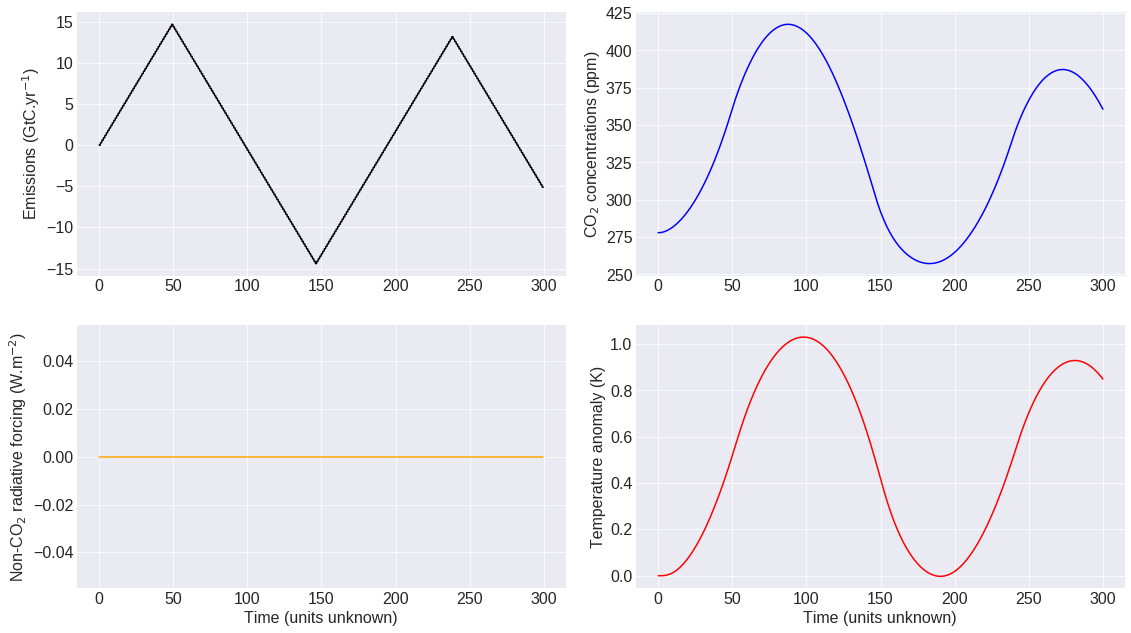

In [38]:
ts_run = fair.scm.FAIR(emissions=np.zeros(300),
                  )
ts_run.C = np.zeros(ts_run.n)
ts_run.T = np.zeros(ts_run.n)

for x in range(-1,len(ts_run.emissions)-1):
    ts_run.x = x        
    # timestep FAIR
    ts_run.time_step()
    # save the results
    ts_run.C[ts_run.x] = ts_run.C_x
    ts_run.T[ts_run.x] = ts_run.T_x
    # make our decision about whether to emit more or less next year
    if ts_run.x < len(ts_run.emissions)-1:
        if (ts_run.T_x > 0.5):
            ts_run.emissions[ts_run.x+1] = ts_run.emissions[ts_run.x] - 0.3
        else:
            ts_run.emissions[ts_run.x+1] = ts_run.emissions[ts_run.x] + 0.3

ts_run.plot()